In [3]:
import os
import glob
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import snpy
import scipy
import george

from multiprocessing import Pool

%config InlineBackend.figure_format = 'retina'
print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'
#BANDS = 'AllBands'  # AllBands, grJH, gr, gp
REF_RESULTS = pd.read_csv('reference_results.txt')

SNooPy version: v2.6.0


In [7]:
def bin_values(bins, x_values, y_values, y_err):
    """Values are binned using the given bins.
    
    Parameters
    ==========
    bins: array
        array of bins
    x_values: array
        array of x-axis values
    y_values: array
        array of y-axis values
    y_err: array
        array of y-axis errors
        
    Returns
    =======
    delta_bins, std_bins, err_bins: arrays
        Arrays of
    """
    
    digitized = np.digitize(x_values, bins)
    delta_bins, std_bins, err_bins = [], [], []
    
    for i in range(1, len(bins)):
        if len(y_values[digitized == i])>0:
            y = y_values[digitized == i]
            w = 1/y_err[digitized == i]**2
            
            wmean = np.average(y, weights=w)
            werr = np.sqrt(np.sum(w*(y- wmean)**2)/((len(w)-1)*np.sum(w)))
            wstd = np.sqrt(np.average((y - wmean)**2, weights=w))
            
            delta_bins.append(wmean)
            std_bins.append(wstd)
            err_bins.append(werr)
        else:
            delta_bins.append(np.nan)
            std_bins.append(np.nan)
            err_bins.append(np.nan)

    delta_bins, std_bins, err_bins = np.array(delta_bins), np.array(std_bins), np.array(err_bins)
    
    return delta_bins, std_bins, err_bins


## Single SN comparison

In [62]:
sn_name = 'SN2004ey'
bands = 'AllBands'
n_epochs = 1

#ref
ref_df = REF_RESULTS[REF_RESULTS.name==sn_name]

# sim
sim_file = os.path.join('sim_fits', 
                        sn_name, 
                        f'{sn_name}_{n_epochs}epochs_results.csv')
sim_df = pd.read_csv(sim_file)
sim_df.head()

,comb,m1,m2,m3,Tmax,Tmax_err,st,st_err,gmax,gmax_err,rmax,rmax_err,Jmax,Jmax_err,Hmax,Hmax_err
0,0,-3.185449,NaN,NaN,304.767949,0.033390,1.013331,0.004188,14.753650,0.002330,14.914605,0.002880,15.448273,0.016529,15.766697,0.046192
1,1,1.842832,NaN,NaN,304.767168,0.493452,1.012820,0.004191,14.753449,0.002336,14.914709,0.002886,15.519856,0.074472,15.836595,0.069213
2,2,6.778687,NaN,NaN,304.766313,0.493479,1.012915,0.004195,14.753606,0.002337,14.914325,0.002888,15.434286,0.088950,15.850243,0.075407
3,3,22.807360,NaN,NaN,304.767640,0.103441,1.012781,0.017930,14.753368,0.002336,14.914917,0.002886,15.624907,0.113963,15.760182,0.061703
4,4,33.789521,NaN,NaN,304.766479,0.103473,1.012897,0.004194,14.753578,0.002337,14.914393,0.002887,15.500474,0.083840,15.819637,0.066629


In [63]:
param = 'Jmax'
if param=='Tmax':
    x_units = 'days'
else:
    x_units = 'mag'

# ref
y_ref = ref_df[f'{param}_{bands}'].values[0]

# sim
m1 = sim_df.m1.values
y = sim_df[param].values
yerr = sim_df[param+'_err'].values

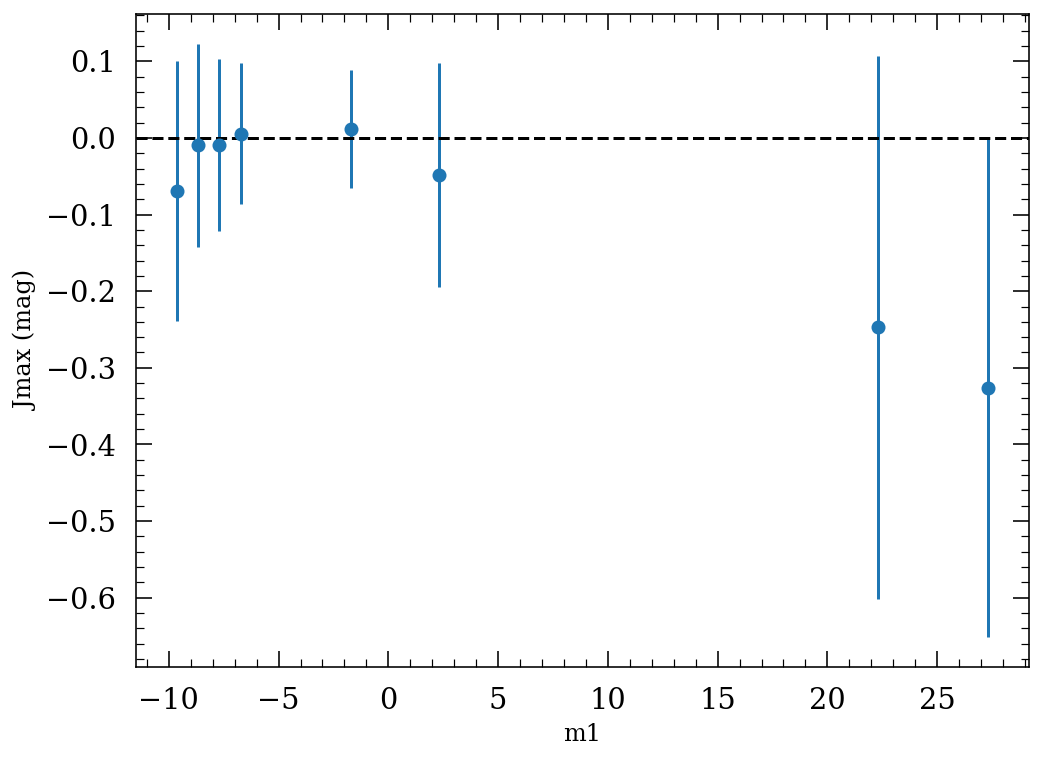

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(m1, y-y_ref, yerr=yerr, fmt='o')
ax.axhline(0, color='k', ls='--')

ax.set_xlabel('m1')
ax.set_ylabel(f'{param} residual ({x_units})')
plt.show()

## Multiple SNe comparison

In [4]:
# SNe to remove
df1 = pd.read_csv('sne_wo_JorH.txt', names=['name', 'bands'], delim_whitespace=True)
df2 = pd.read_csv('sne_wo_opt_max.txt', names=['name', 'comment'], delim_whitespace=True)
df3 = pd.read_csv('sne_wo_nir_max.txt', names=['name', 'comment'], delim_whitespace=True)
del_df = pd.concat([df1, df2, df3])
files2remove = [f'csp_dr3/{name}_snpy.txt' for name in list(del_df.name.values)]

sn_names = [file.split('/')[-1].split('_')[0] for file in glob.glob('csp_dr3/*.txt') 
                                                            if file not in files2remove]

In [5]:
bands = 'AllBands'
n_epochs = 1

param = 'Hmax'
if param=='Tmax':
    x_units = 'days'
else:
    x_units = 'mag'

In [ ]:
# binned data
bins = np.arange(14, 26)
delta_bins, std_bins, err_bins = bin_values(bins, salt2_vals, pisco_vals,
                                            pisco_err, salt2_vals)

# plot
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True, gridspec_kw={'hspace':0.0})

# residual
ax[0].errorbar(salt2_vals, delta_mb, yerr=pisco_err, 
            capsize=3, fmt='o', color='seagreen', alpha=0.8, mec='k', ms=10)        
ax[0].errorbar(bins[:-1]+0.5, delta_bins, err_bins, 
            color='red', zorder=18, ms=14, mec='k', fmt='h', ecolor='red', 
            capsize=8, capthick=2, elinewidth=2.5)

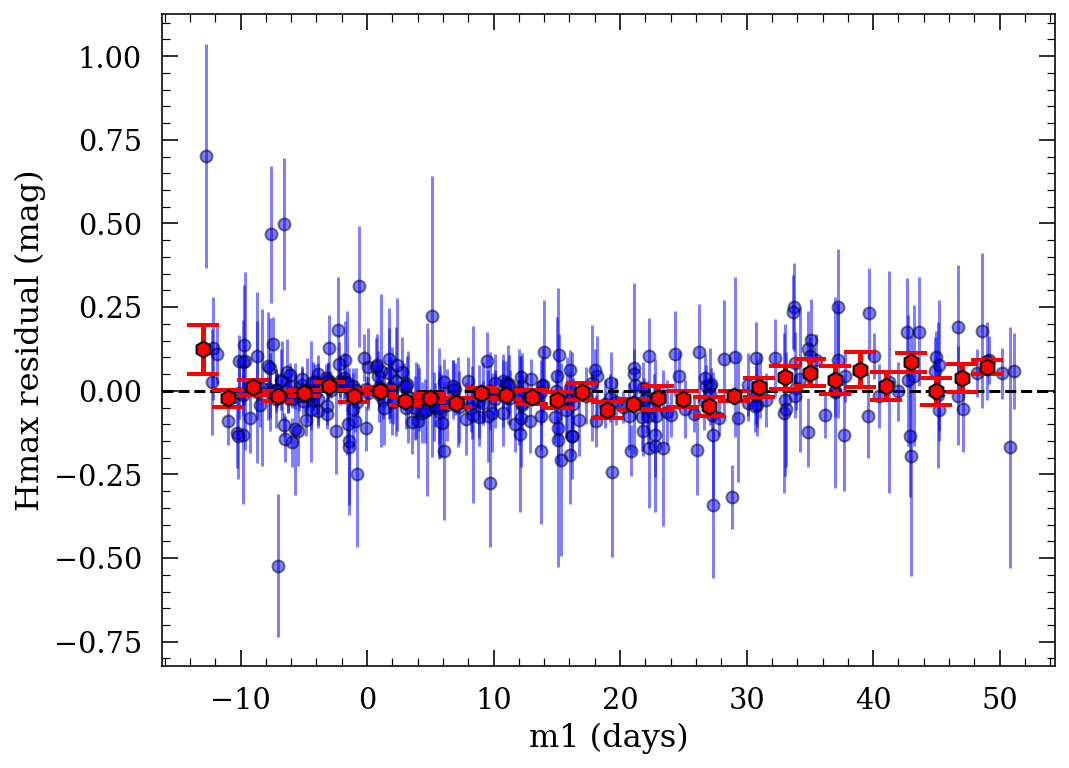

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

X, Y, YERR = [], [], []
for sn_name in sn_names:
    try:
        #ref
        ref_df = REF_RESULTS[REF_RESULTS.name==sn_name]
        y_ref = ref_df[f'{param}_{bands}'].values[0]

        # sim
        sim_file = os.path.join('sim_fits', 
                                sn_name, 
                                f'{sn_name}_{n_epochs}epochs_results.csv')
        sim_df = pd.read_csv(sim_file)
        m1 = sim_df.m1.values
        y = sim_df[param].values
        yerr = sim_df[param+'_err'].values        

        # plot
        ax.errorbar(m1, y-y_ref, yerr=yerr, 
                            fmt='o', color='b', alpha=0.5,
                            mec='k')
        
        X.append(m1), Y.append(y-y_ref), YERR.append(yerr)
    except:
        pass
    
# bins
X = np.array([item for sublist in X for item in sublist])
Y = np.array([item for sublist in Y for item in sublist])
YERR = np.array([item for sublist in YERR for item in sublist])

bins = np.arange(np.round(X, 0).min(), np.round(X+1, 0).max(), 2)
delta_bins, std_bins, err_bins = bin_values(bins, X, Y, YERR)
ax.errorbar(bins[:-1], delta_bins, err_bins, 
            color='red', zorder=18, ms=8, mec='k', fmt='h', ecolor='red', 
            capsize=8, capthick=2, elinewidth=2.5)
    
ax.axhline(0, color='k', ls='--')
ax.set_xlabel('m1 (days)', fontsize=16)
ax.set_ylabel(f'{param} residual ({x_units})', fontsize=16)
plt.show()

In [54]:
def plot(param, bands, n_epochs, ax):
    x_units = 'mag'
    X, Y, YERR = [], [], []
    for sn_name in REF_RESULTS.name:
        try:
            #ref
            ref_df = REF_RESULTS[REF_RESULTS.name==sn_name]
            y_ref = ref_df[f'{param}_{bands}'].values[0]

            # sim
            sim_file = os.path.join('sim_fits', 
                                    sn_name, 
                                    f'{sn_name}_{n_epochs}epochs_results.csv')
            sim_df = pd.read_csv(sim_file)
            m1 = sim_df.m1.values
            y = sim_df[param].values
            yerr = sim_df[param+'_err'].values        

            # plot
            ax.errorbar(m1, y-y_ref, yerr=yerr, 
                                fmt='o', color='b', alpha=0.5,
                                mec='k')

            X.append(m1), Y.append(y-y_ref), YERR.append(yerr)
        except:
            pass

    # bins
    X = np.array([item for sublist in X for item in sublist])
    Y = np.array([item for sublist in Y for item in sublist])
    YERR = np.array([item for sublist in YERR for item in sublist])

    bins = np.arange(np.round(X, 0).min(), np.round(X+1, 0).max(), 2)
    delta_bins, std_bins, err_bins = bin_values(bins, X, Y, YERR)
    ax.errorbar(bins[:-1], delta_bins, err_bins, 
                color='red', zorder=18, ms=8, mec='k', fmt='h', ecolor='red', 
                capsize=8, capthick=2, elinewidth=2.5)
    
    #ax.text(-10, -0.4, np.average(Y, weights=1/YERR**2))

    ax.axhline(0, color='k', ls='--')
    ax.set_xlabel('m1 (days)', fontsize=16)
    ax.set_ylabel(f'{param} residual ({x_units})', fontsize=16)
    
    return ax

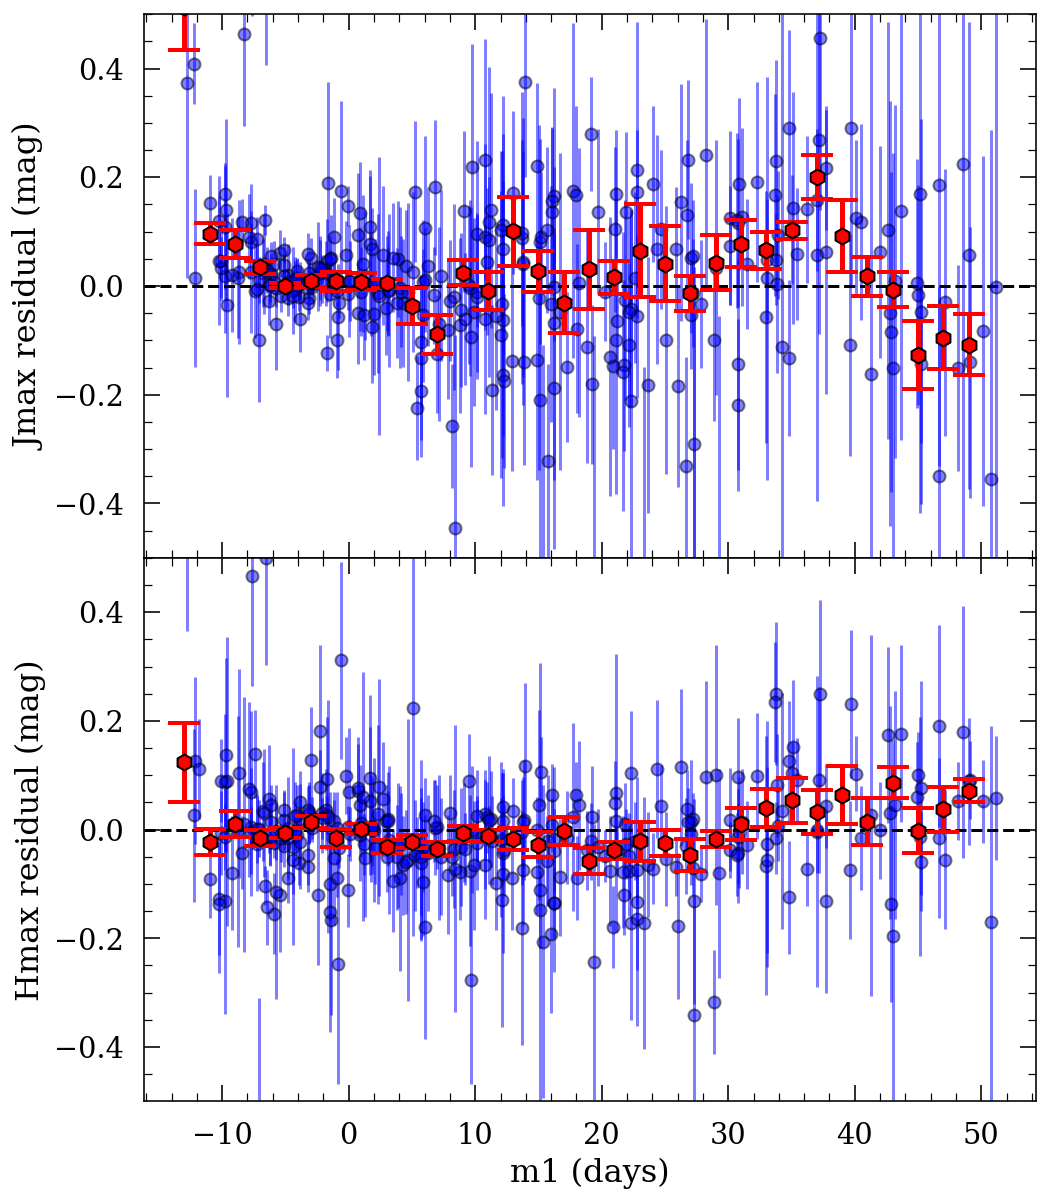

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True, 
                                       gridspec_kw={'hspace':0})
ax[0] = plot('Jmax', bands, n_epochs, ax[0])
ax[1] = plot('Hmax', bands, n_epochs, ax[1])

ax[0].set_ylim(-0.5, 0.5)
ax[1].set_ylim(-0.5, 0.5)
plt.show()